In [1]:
import os
import numpy as np
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
train_transform = transforms.Compose([
    # transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomInvert(p=0.5),
    transforms.ToTensor()
])

In [7]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
train_data = datasets.ImageFolder(
    root = os.path.join("./data", "train"),
    transform=train_transform)

#Test
test_data = datasets.ImageFolder(
    root = os.path.join("./data", "test"),
    transform=test_transform)

In [9]:
#Train
train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = 16,
    pin_memory=True)

#Test
test_loader = DataLoader(
    test_data,
    batch_size = 16,
    pin_memory=True)

In [10]:
class_names = train_data.classes
for image,label in train_loader:
    print('Size (b x ch x w x h)): ',image.shape, '\tImage Classes->',class_names)
    break

Size (b x ch x w x h)):  torch.Size([16, 3, 600, 800]) 	Image Classes-> ['down', 'left', 'right', 'up', 'x']


In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, kernel_size=5, out_channels=16, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, kernel_size=5, out_channels=32, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, kernel_size=5, out_channels=64, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, kernel_size=5, out_channels=128, stride=2, padding=1)
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.out = nn.Linear(64,5)
    
    def forward(self,X):
        # print(X.shape)
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        # print(X.shape)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        # print(X.shape)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        # print(X.shape)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,2,2)

        X = X.view(X.size()[0], -1)
        # print(X.shape)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))

        
        X = self.out(X)
        return F.log_softmax(X,dim = 1)
    
def get_predictions(model, data_loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predictions.append(probabilities.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(labels)

In [13]:
model = CNNModel()
model = model.to(device)

In [14]:
epochs = 70
train_losses = []
train_correct = []
test_losses = []
test_correct = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
min_loss = 100000
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b,(X_train,Y_train) in enumerate(train_loader):
        b+=1
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)
        Y_pred = model(X_train)
        loss = criterion(Y_pred,Y_train)
        predictions = torch.max(Y_pred.data,1)[1]
        trn_corr+= (predictions == Y_train).sum()
        
        print('.' ,end='')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for(X_test,Y_test) in test_loader:
            X_test = X_test.to(device)
            Y_test = Y_test.to(device)
            Y_val = model(X_test)
            predictions = torch.max(Y_val.data,1)[1]
            tst_corr+= (predictions == Y_test).sum()
        loss = criterion(Y_val,Y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        print("\nEpoch: {}, test loss: {:.4f}\n".format(i, loss))
        if loss < min_loss:
            min_loss = loss
            torch.save(model.state_dict(), os.path.join("./models", "pokebot.pth"))
            print(f"New Minimum Loss: {loss} -> Model Saved")
        else:
            print(f"Minimum loss {min_loss} didn't change.")

In [18]:
torch.save(model.state_dict(), os.path.join("./models", "pokebot.pth"))
print("Saved PyTorch Model State to pokebot.pth")

Saved PyTorch Model State to pokebot.pth


In [19]:
model = CNNModel()
model.load_state_dict(torch.load(os.path.join("./models", "pokebot.pth")))

<All keys matched successfully>

In [34]:
for t in test_loader:
    print(t[0].shape)
    break

torch.Size([16, 3, 600, 800])


In [22]:
model = model.to(device)
y_score, y_true = get_predictions(model, test_loader)

In [23]:
from sklearn.preprocessing import label_binarize

n_classes = 5

y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

In [25]:
# Compute ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

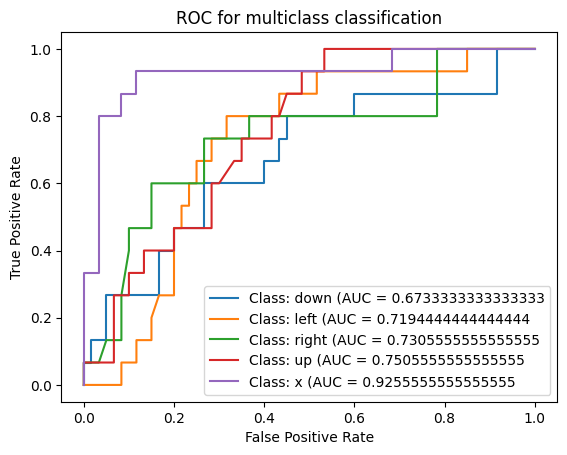

In [27]:
# Plot ROC curve for each class
import matplotlib.pyplot as plt
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class: {class_names[i]} (AUC = {roc_auc[i]}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multiclass classification')
plt.legend(loc='lower right')
plt.show()